In [598]:
import os, sys, json
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from collections import defaultdict
from tabulate import tabulate
from IPython.core.display import display, HTML

# Increase display width
display(HTML("<style>.container { width:80% !important; }</style>"))

# Some styling
plt.style.use('ggplot')
# plt.rcParams['figure.figsize'] = 10, 10

In [641]:
# We reuse these over and over and it's easier to have them in a list than unordered dict
model_names = ["wgan", "wgpgan", "nsgan", "mmgan", "ragan", 
               "lsgan", "dragan", "began", "infogan", "fishergan", 
               "fgan_forward_kl", "fgan_reverse_kl", "fgan_jensen_shannon",
               "fgan_total_var", "fgan_hellinger", "fgan_pearson"]
distance_metrics=["KL-Divergence", "Jensen-Shannon", "Wasserstein-Distance", "Energy-Distance"]
distributions=['normal', 'beta', 'gumbel', 'laplace', 'exponential', 'gamma']

# Colors
palette = ["#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c", "#98df8a", "#d62728", "#ff9896", "#9467bd",
            "#c5b0d5", "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f", "#c7c7c7", "#bcbd22" "#dbdb8d",
            "#17becf", "#9edae5"]

# For subplotting
plt_idx = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

def get_confidence_intervals_multivariate(mypath):

    # Get file path and files therein
    files = os.listdir(mypath)
    results = []

    # Load files
    for file in files:

        if file == '.DS_Store':
            continue

        with open("{}/{}".format(mypath, file)) as f:
            data = json.load(f)
        
        results.append(data)
        
    # Get values for best runs
    optimal = nested_pickle_dict()
    for result in results:
        for model, distributions in result.items():
            for distribution, metrics in distributions.items():
                for metric, values in metrics.items():
                    if metric not in optimal[model][distribution]:
                        optimal[model][distribution][metric] = {'values': [], "parameters": []}
                    
                    if metric not in ['DLoss', 'GLoss', "LR", "HDIM", "BSIZE"]:
                        # Note we are excluding these metrics for space
                        optimal[model][distribution][metric]['values'].append(values['value'])
                        optimal[model][distribution][metric]["parameters"].append(values["parameters"])

    # Compute 5th and 95th percentiles for each epoch
    for result in results:
        for model, distributions in result.items():
            for distribution, metrics in distributions.items():
                for metric, values in metrics.items():
                    if metric not in ['DLoss', 'GLoss']:
                        data = np.column_stack(optimal[model][distribution][metric]['values'])
                        mean, h, low, high = mean_confidence_interval(data)
                        optimal[model][distribution][metric]['low'] = list(low)
                        optimal[model][distribution][metric]['h'] = h
                        optimal[model][distribution][metric]['mean'] = list(mean)
                        optimal[model][distribution][metric]['high'] = list(high)
                    
                        
    return optimal

    
def graph_multivariate(optimal, 
                       omit_outliers=True,
                       thresh=8.5,
                       plt_idx=plt_idx,
                       model_names=model_names,
                       distance_metrics=distance_metrics,
                       distributions=distributions,
                       palette=palette):
    
    for metric in distance_metrics:

        fig, axes = plt.subplots(2, 3, sharex=True, sharey=False, figsize=(20,20))

        for d_idx, distribution in enumerate(distributions):

            for idx, model_name in enumerate(model_names):

                if model_name in ['vae', 'autoencoder']:
                    continue
                    
                data = optimal[model_name][distribution][metric]['mean']
                
                if omit_outliers:
                    # Remove outliers
                    data = np.array(data)
                    notnan_indexes = ~np.isnan(data)
                    no_outliers = data.flatten()[~is_outlier(data[notnan_indexes], thresh=thresh)]

                    axes[plt_idx[d_idx][0], plt_idx[d_idx][1]].plot(np.linspace(1, data.shape[0]+1, no_outliers.shape[0]),
                                                                     no_outliers,
                                                                     label=model_name,
                                                                     c=palette[idx])
                    
                else:

                    axes[plt_idx[d_idx][0], plt_idx[d_idx][1]].plot(range(1, len(data)+1),
                                                                     data,
                                                                     c=palette[idx],
                                                                     label=model_name)
                
                axes[plt_idx[d_idx][0], plt_idx[d_idx][1]].set_title("{0}".format(distribution.capitalize()))
            
            
        fig.suptitle("{0}".format(metric), fontsize=22)
        fig.text(0.5, 0.04, "Epoch", ha='center', fontsize=18)
        plt.legend(loc='center left', bbox_to_anchor=(1, 1), fontsize=18)
        plt.show()
#         plt.savefig('../graphs/multivariate/{0}_{1}_{2}.png'.format(metric, dims, samples), dpi=100)

            
def mean_confidence_interval(data, axis=1, confidence=0.95):
    try:
        n = data.shape[axis]
    except IndexError:
        axis = 0
        n = data.shape[axis]

    mu, std = np.nanmean(data, axis=axis), scipy.stats.sem(data, axis=axis, nan_policy='omit')
    h = np.ma.getdata(std) * scipy.stats.t.ppf((1 + confidence) / 2., n-1)       

    return mu, h, mu-h, mu+h


def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh


def nested_pickle_dict():
    """ Picklable defaultdict nested dictionaries """
    return defaultdict(nested_pickle_dict)

In [642]:
optimal_1000 = get_confidence_intervals_multivariate("/Users/sob/Desktop/gan_results/best/multivariate/16_dims_1000_samples/")
optimal_10000 = get_confidence_intervals_multivariate("/Users/sob/Desktop/gan_results/best/multivariate/16_dims_10000_samples/")
optimal_100000 = get_confidence_intervals_multivariate("/Users/sob/Desktop/gan_results/best/multivariate/16_dims_100000_samples/")

 Plot mean performance across epochs for 1k samples


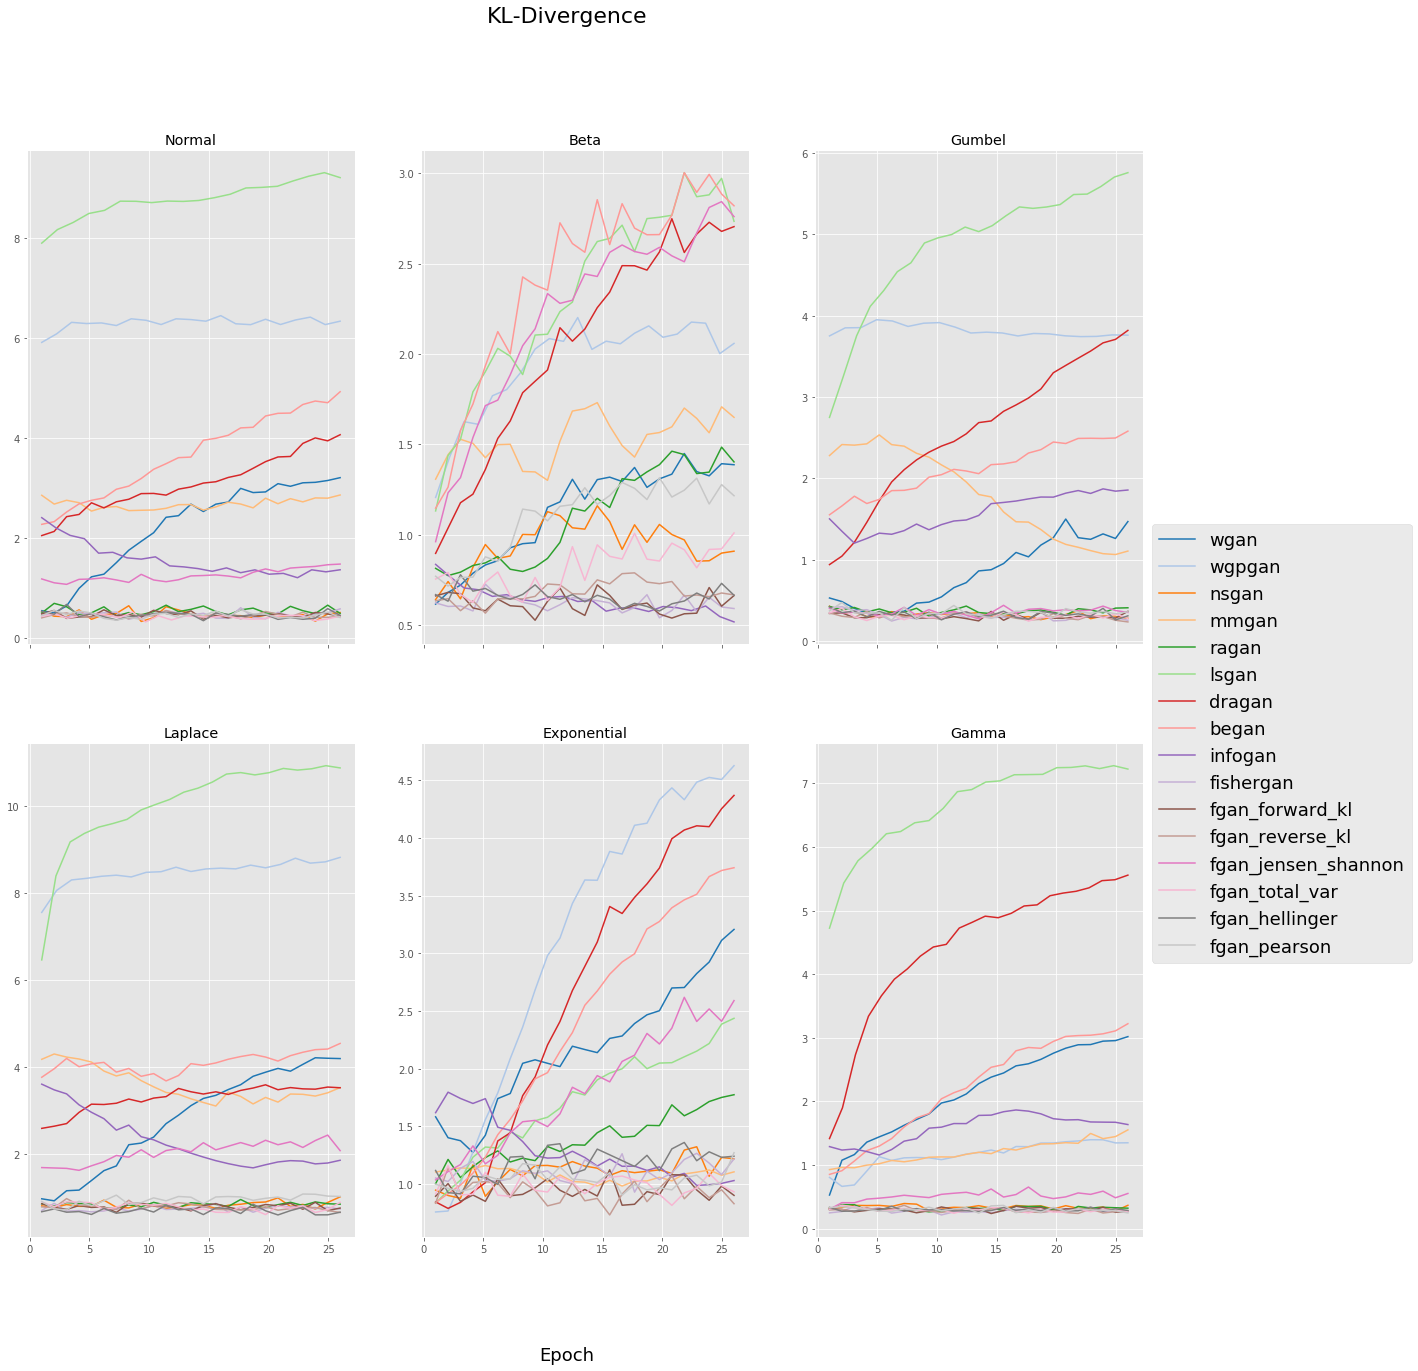

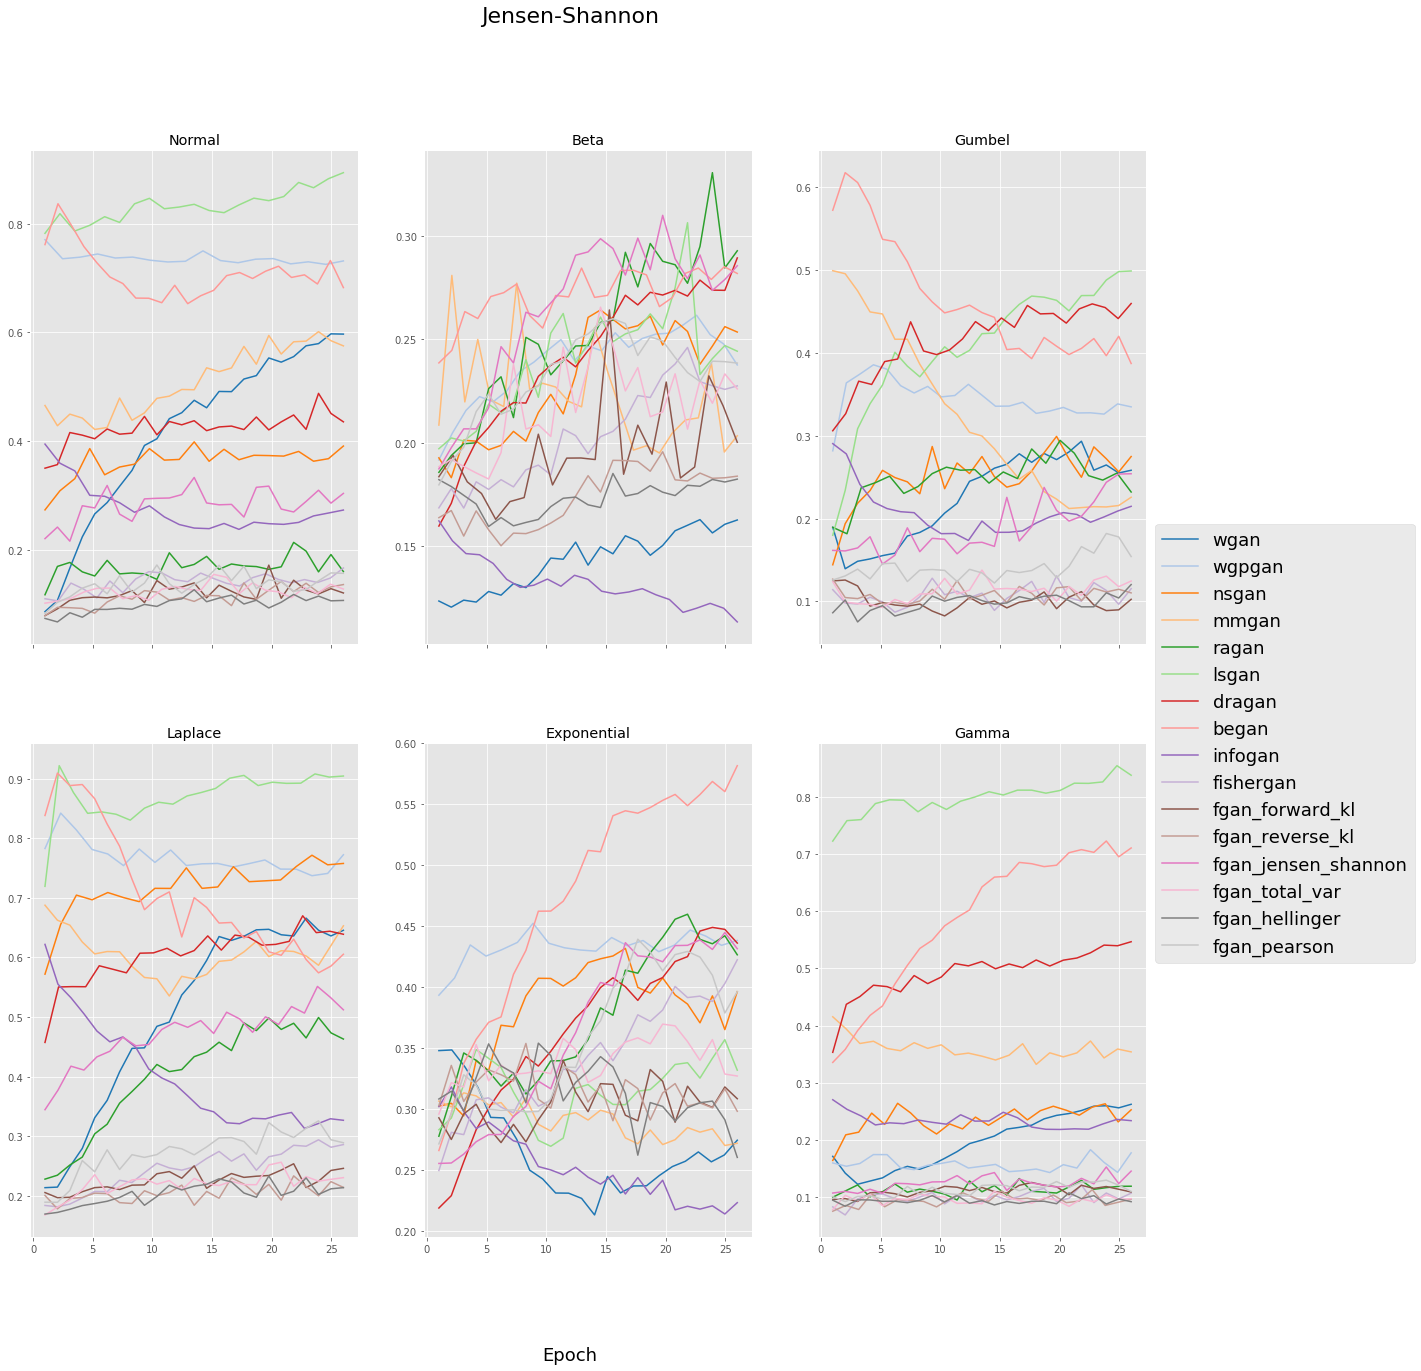

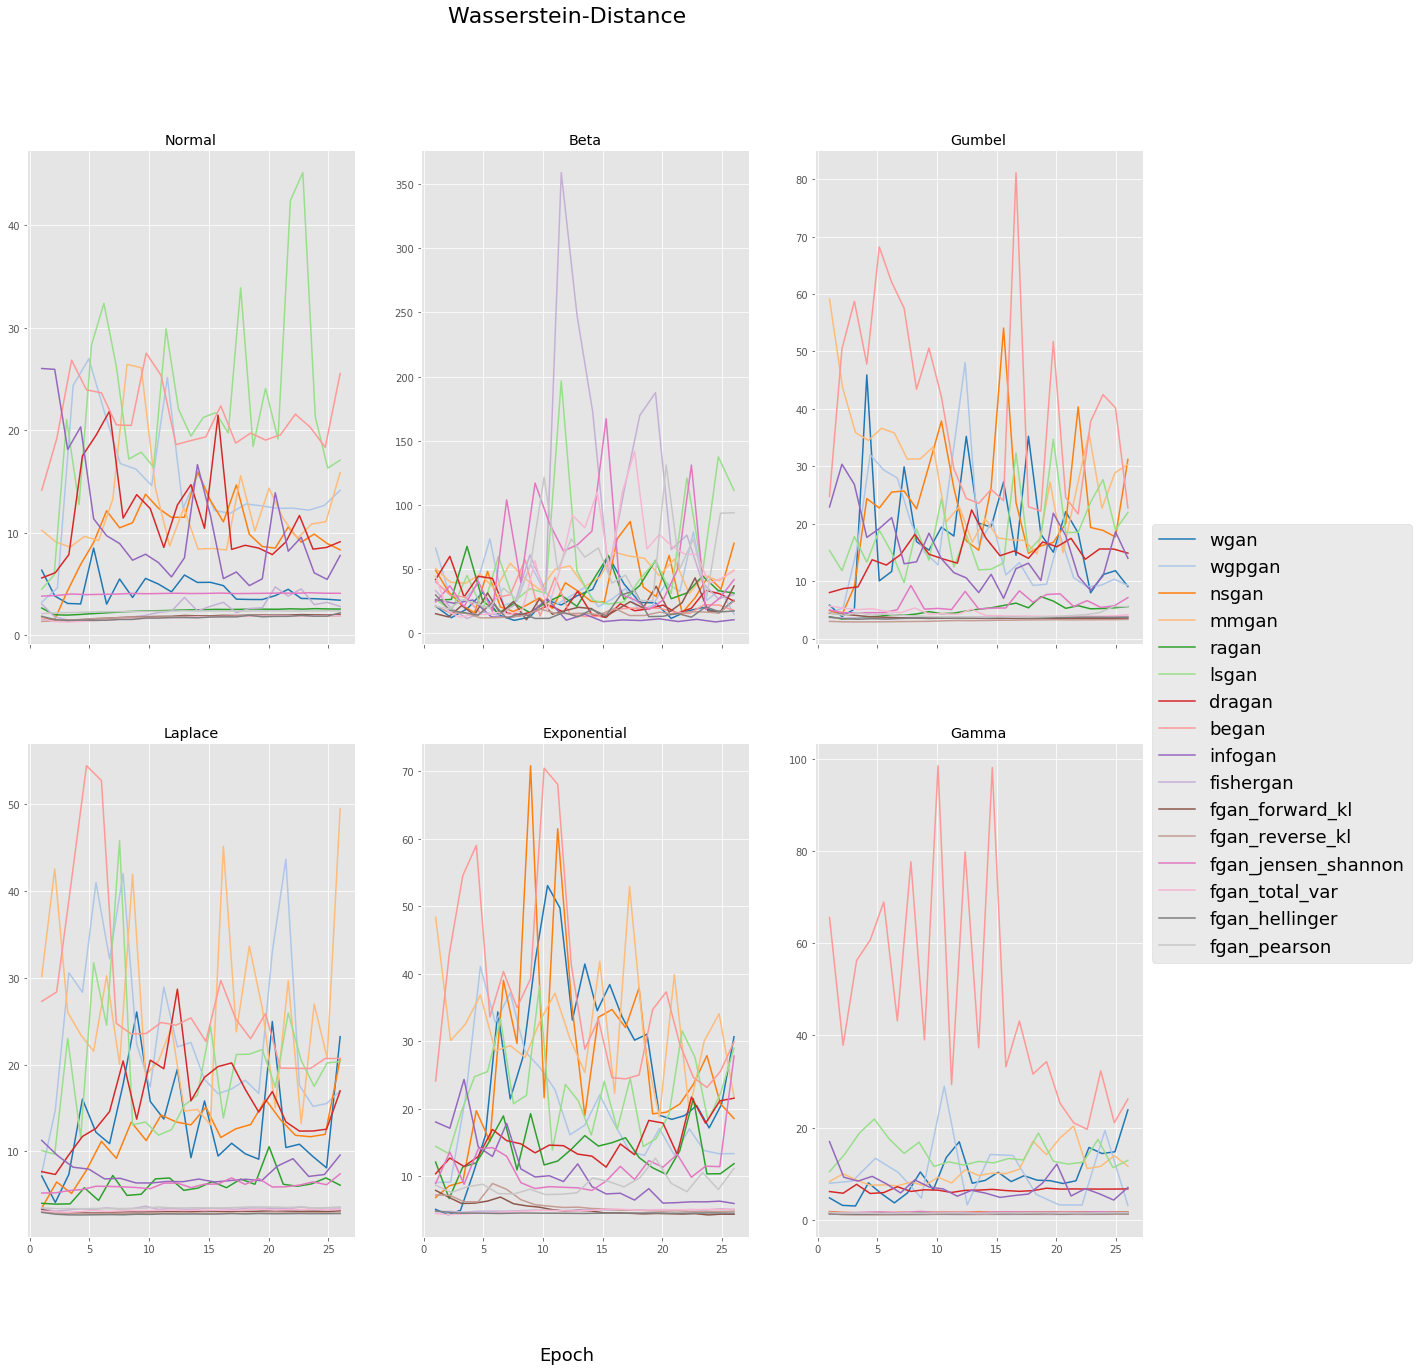

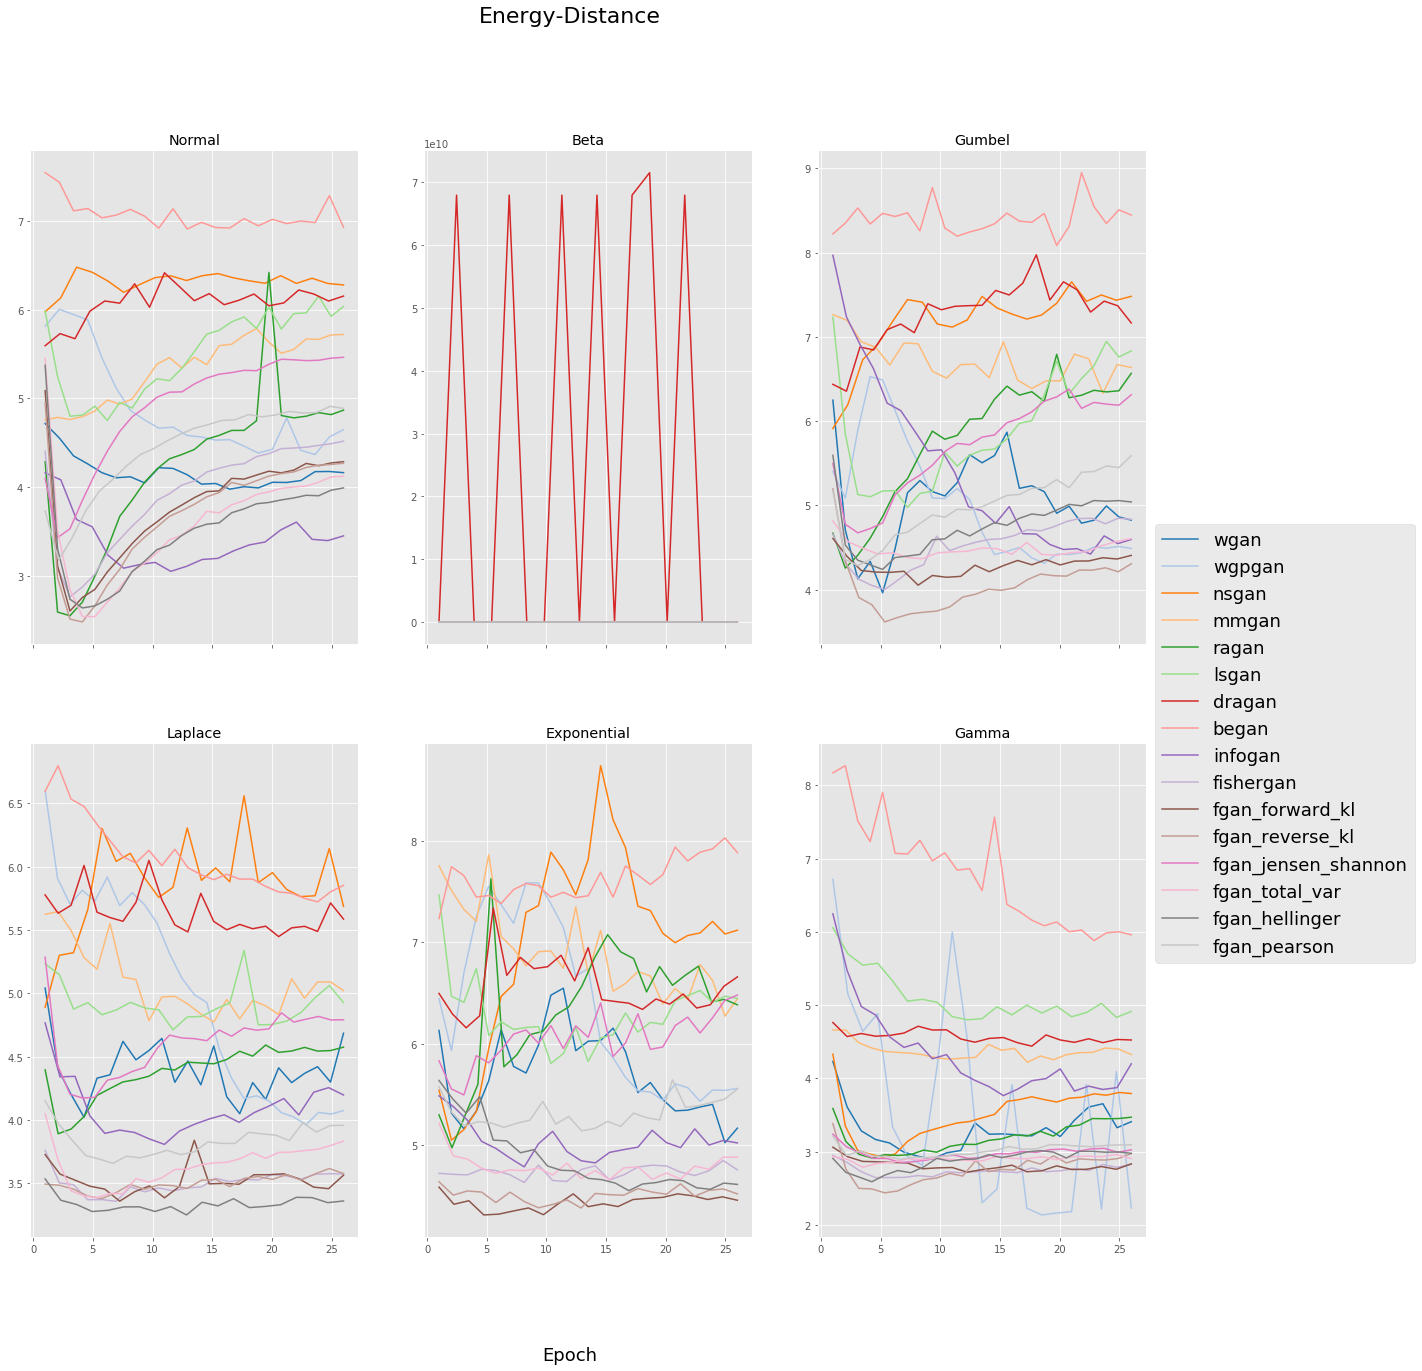

In [643]:
print(""" Plot mean performance across epochs for 1k samples""")
graph_multivariate(optimal_1000, omit_outliers=True, thresh=4.5)

 Plot mean performance across epochs for 10k samples


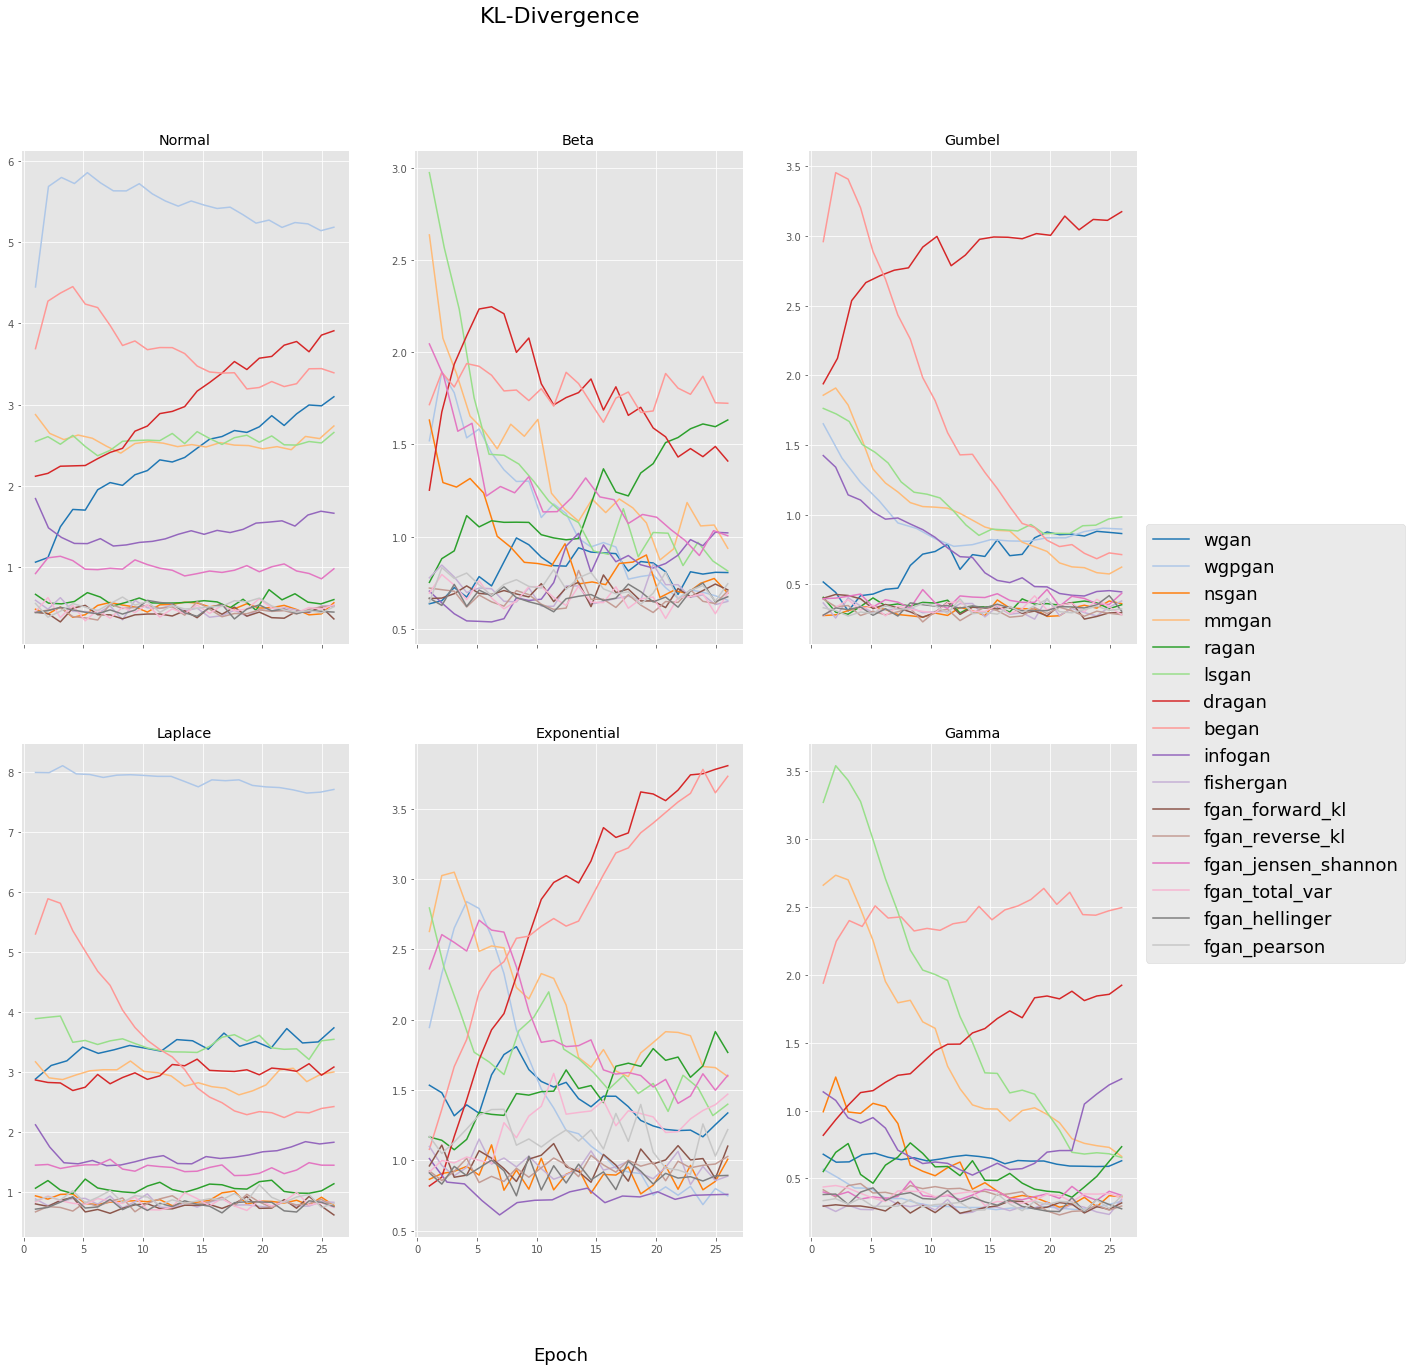

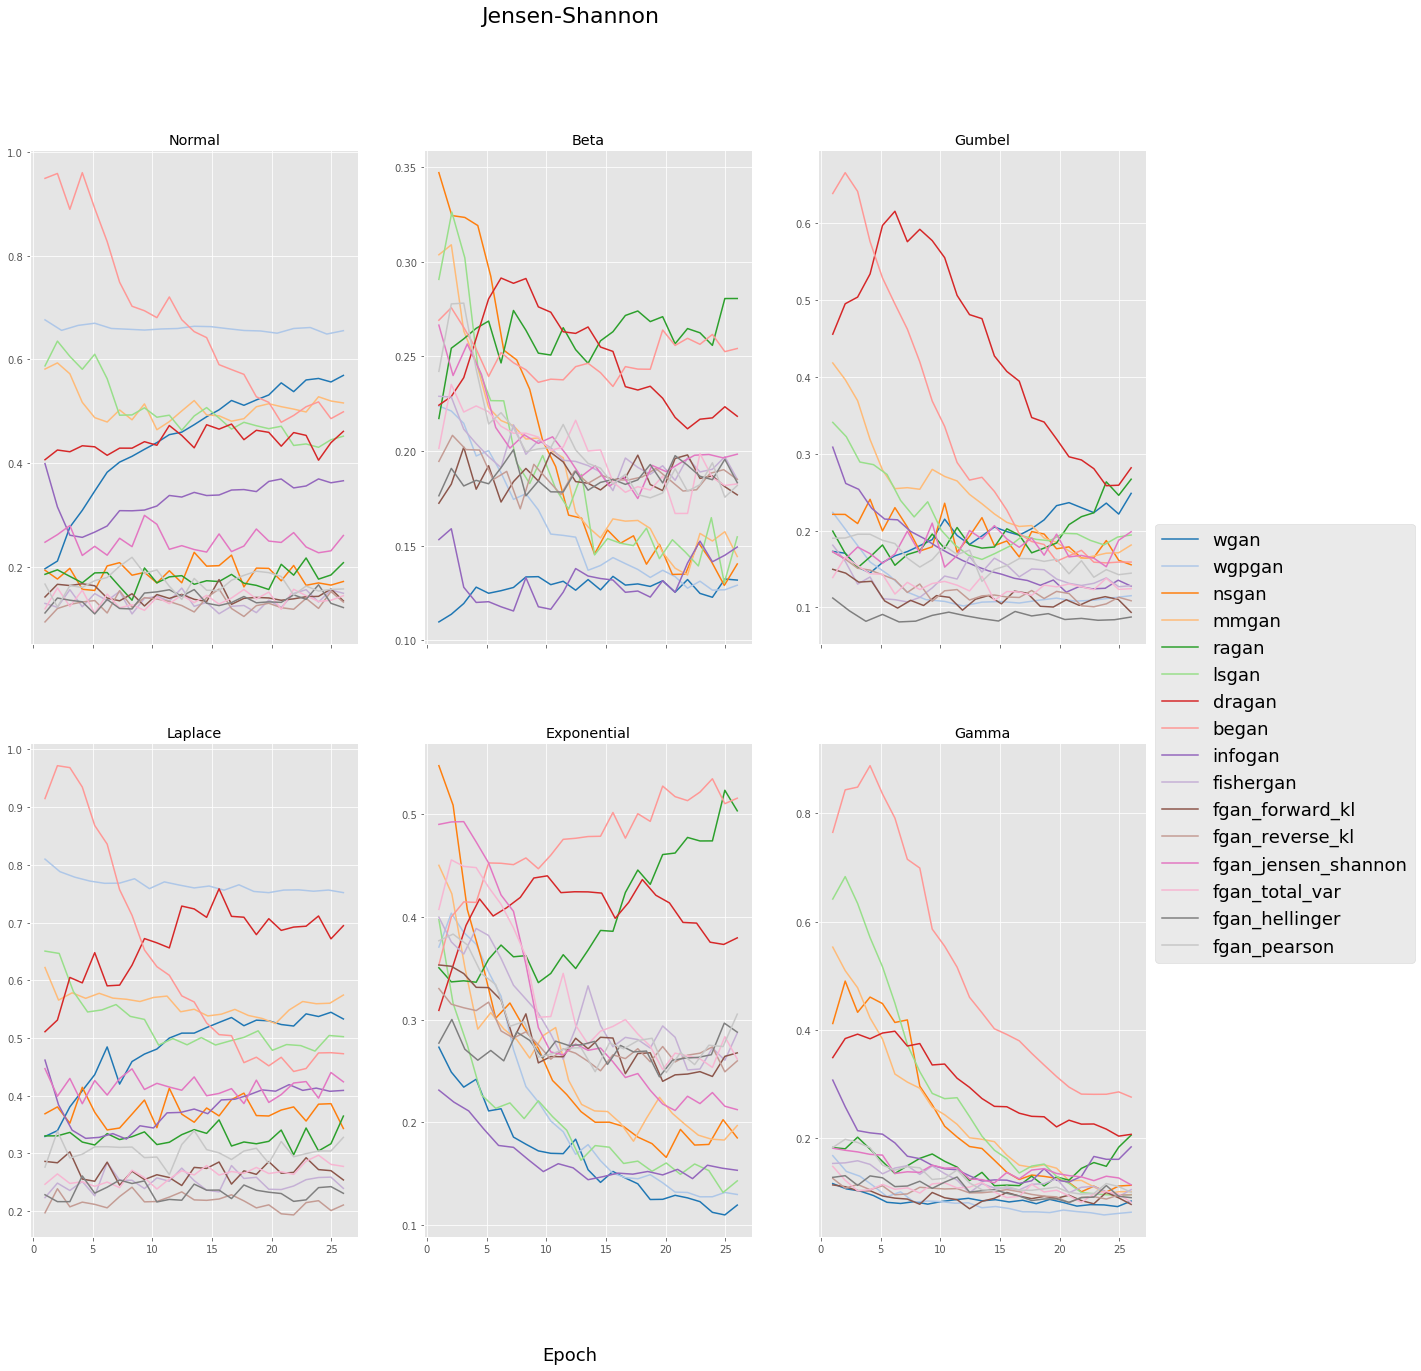

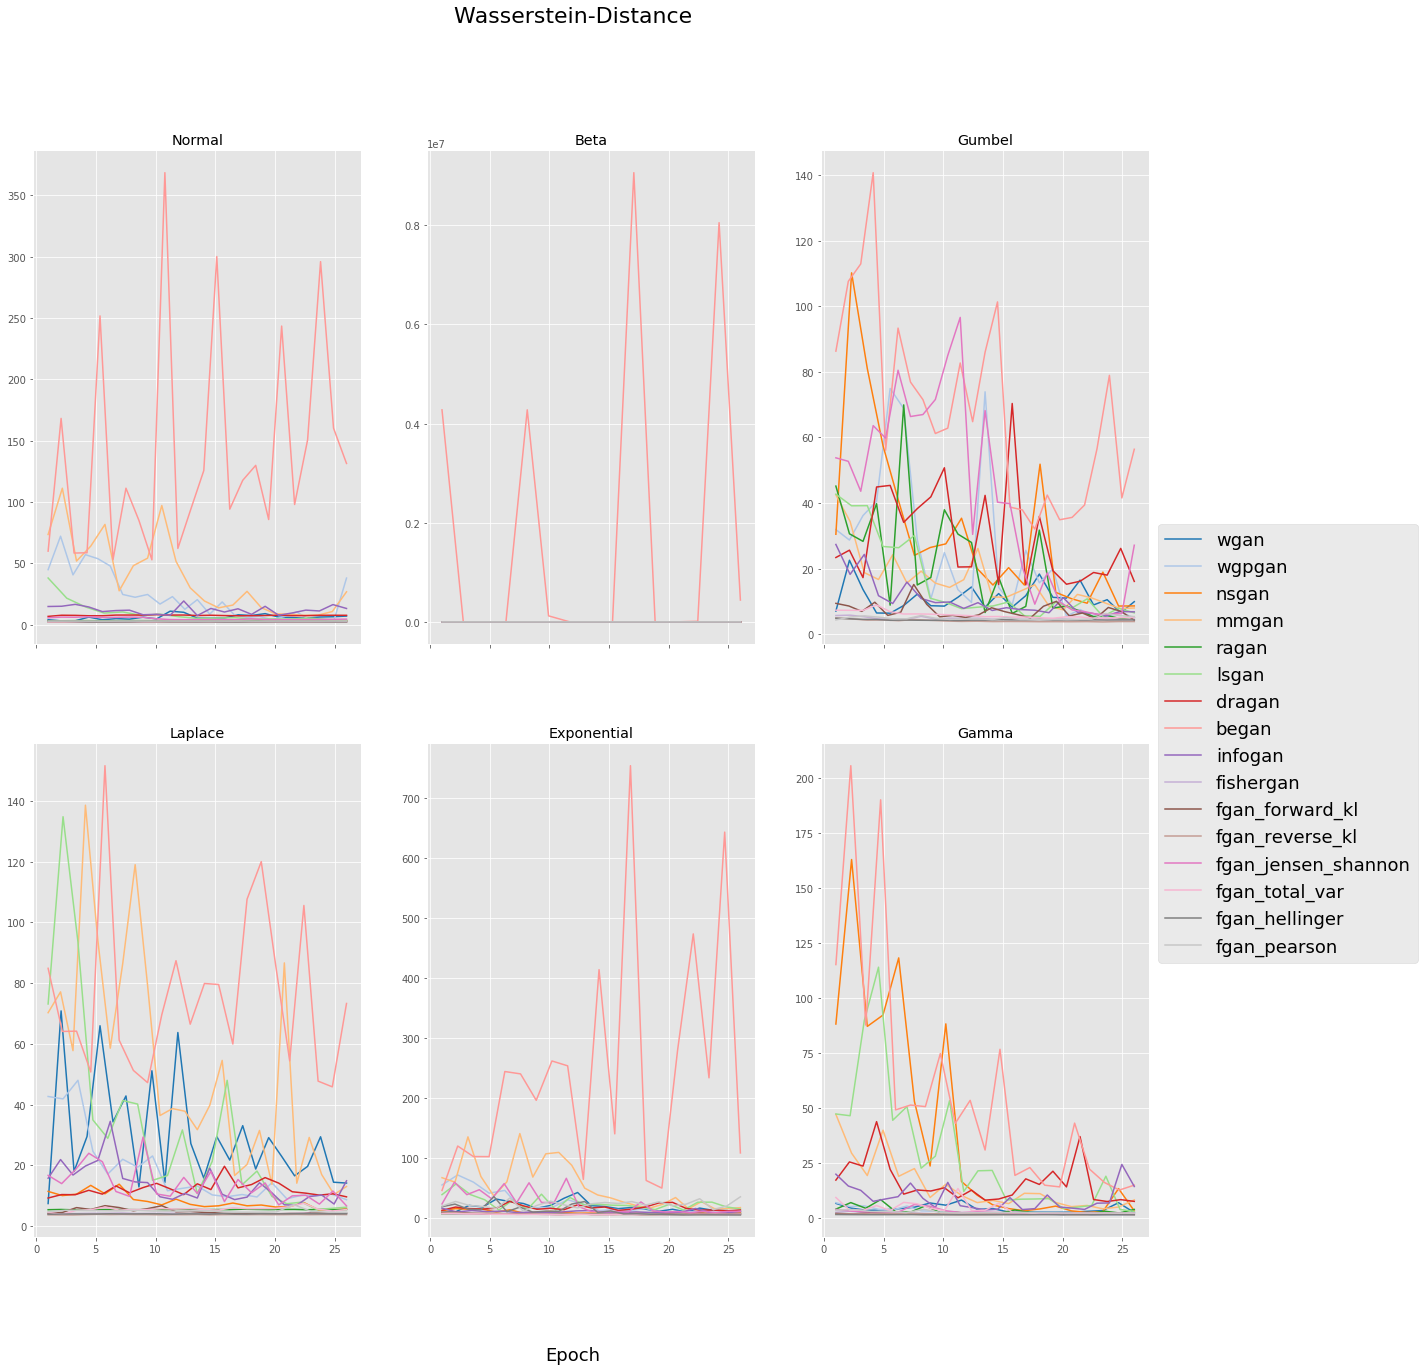

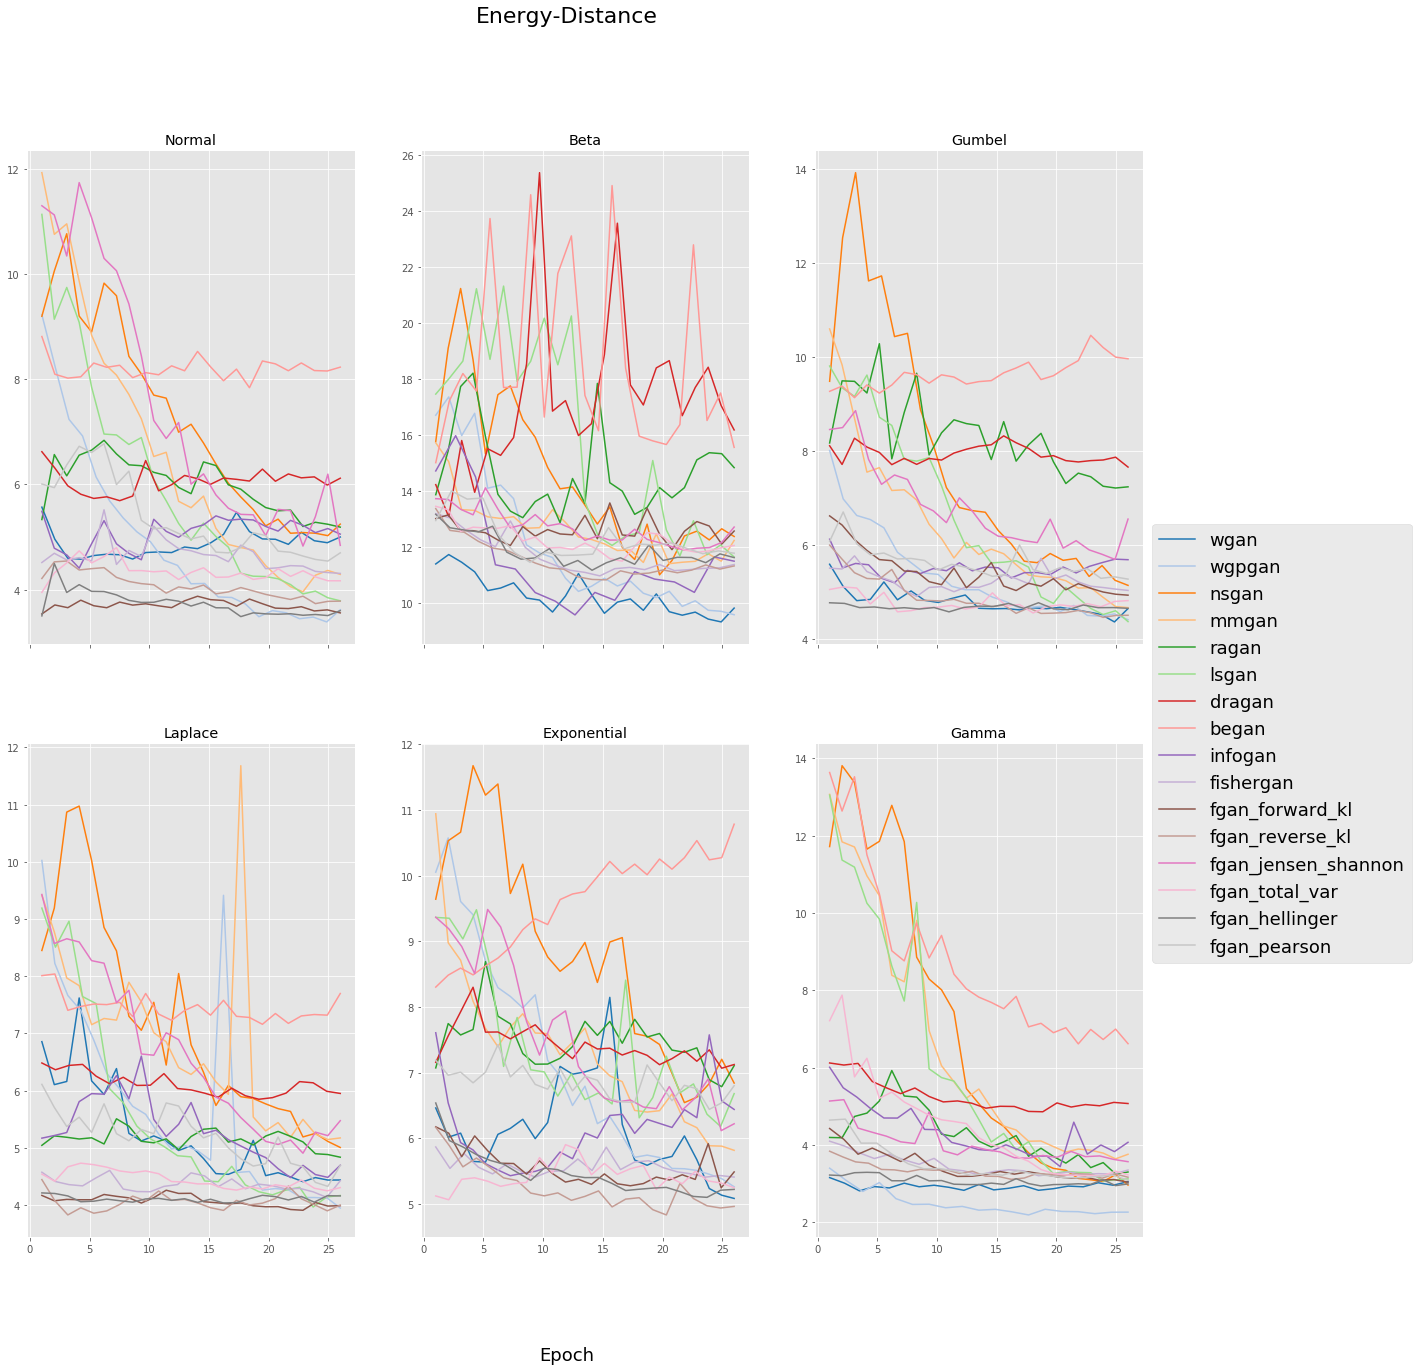

In [644]:
print(""" Plot mean performance across epochs for 10k samples""")
graph_multivariate(optimal_10000, omit_outliers=True, thresh=4.5)

 Plot mean performance across epochs for 100k samples


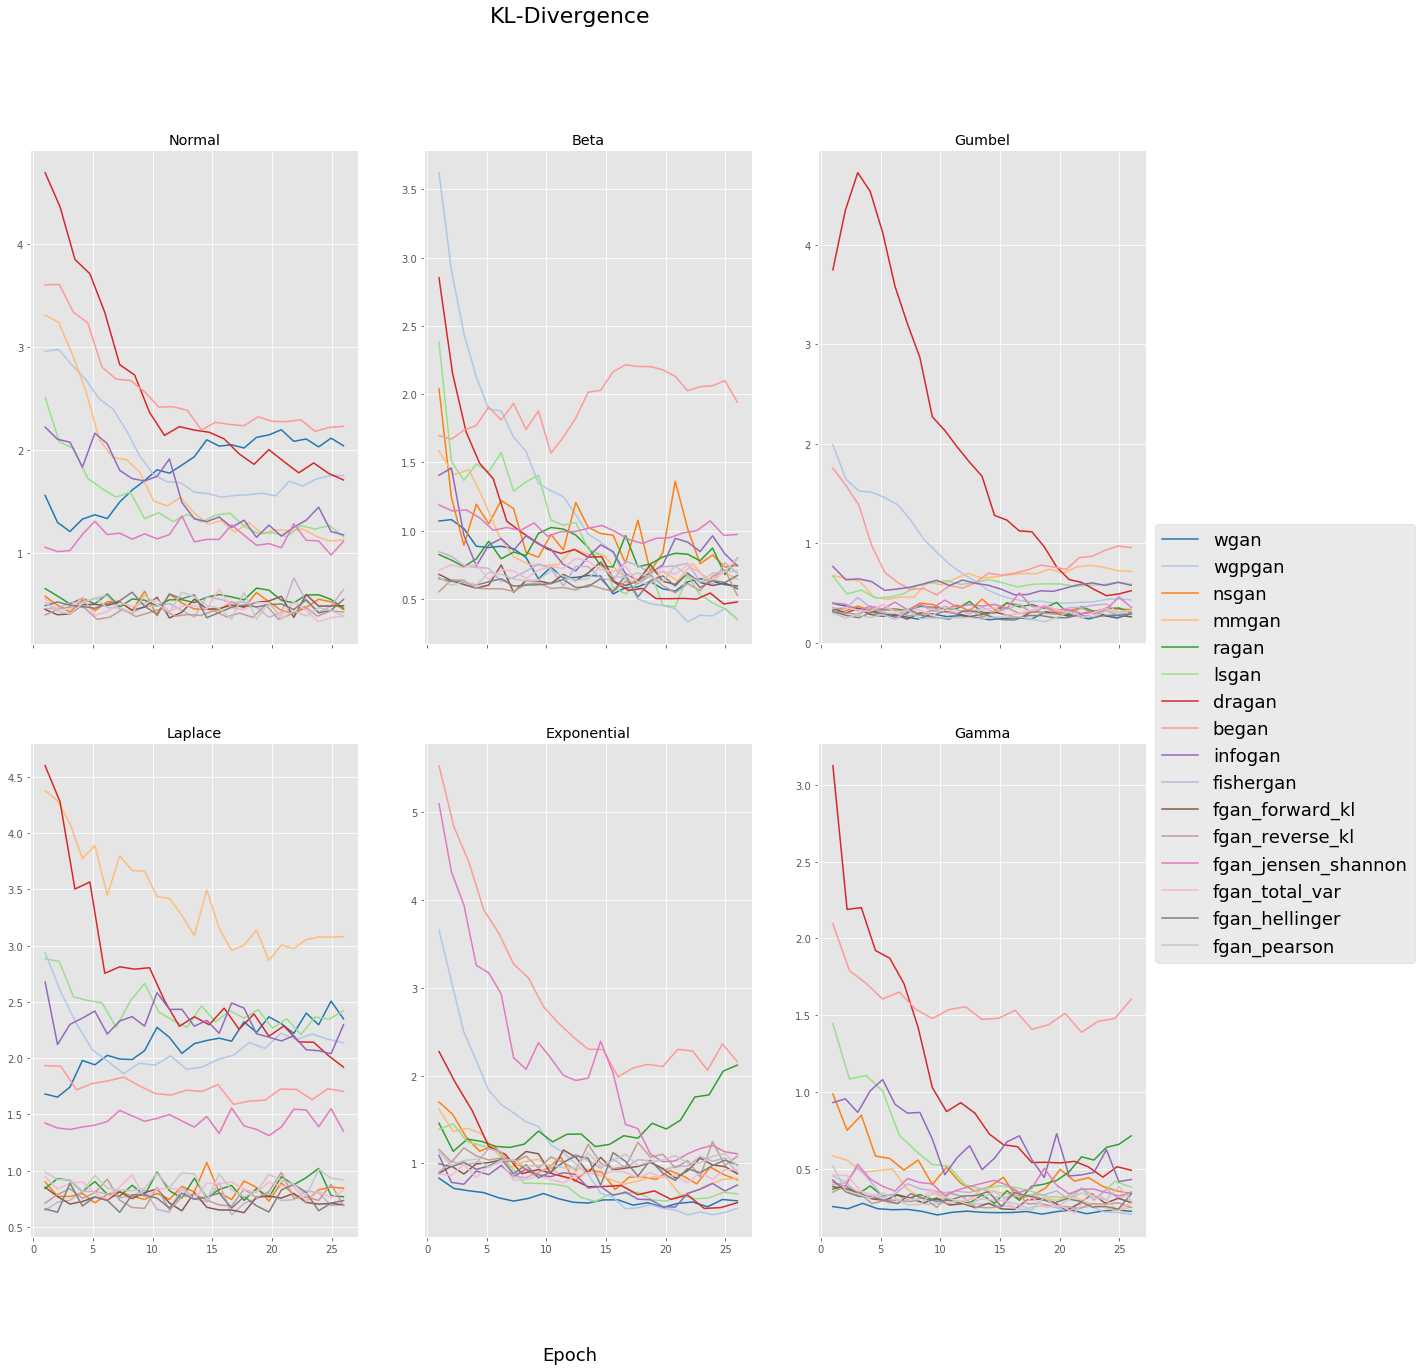

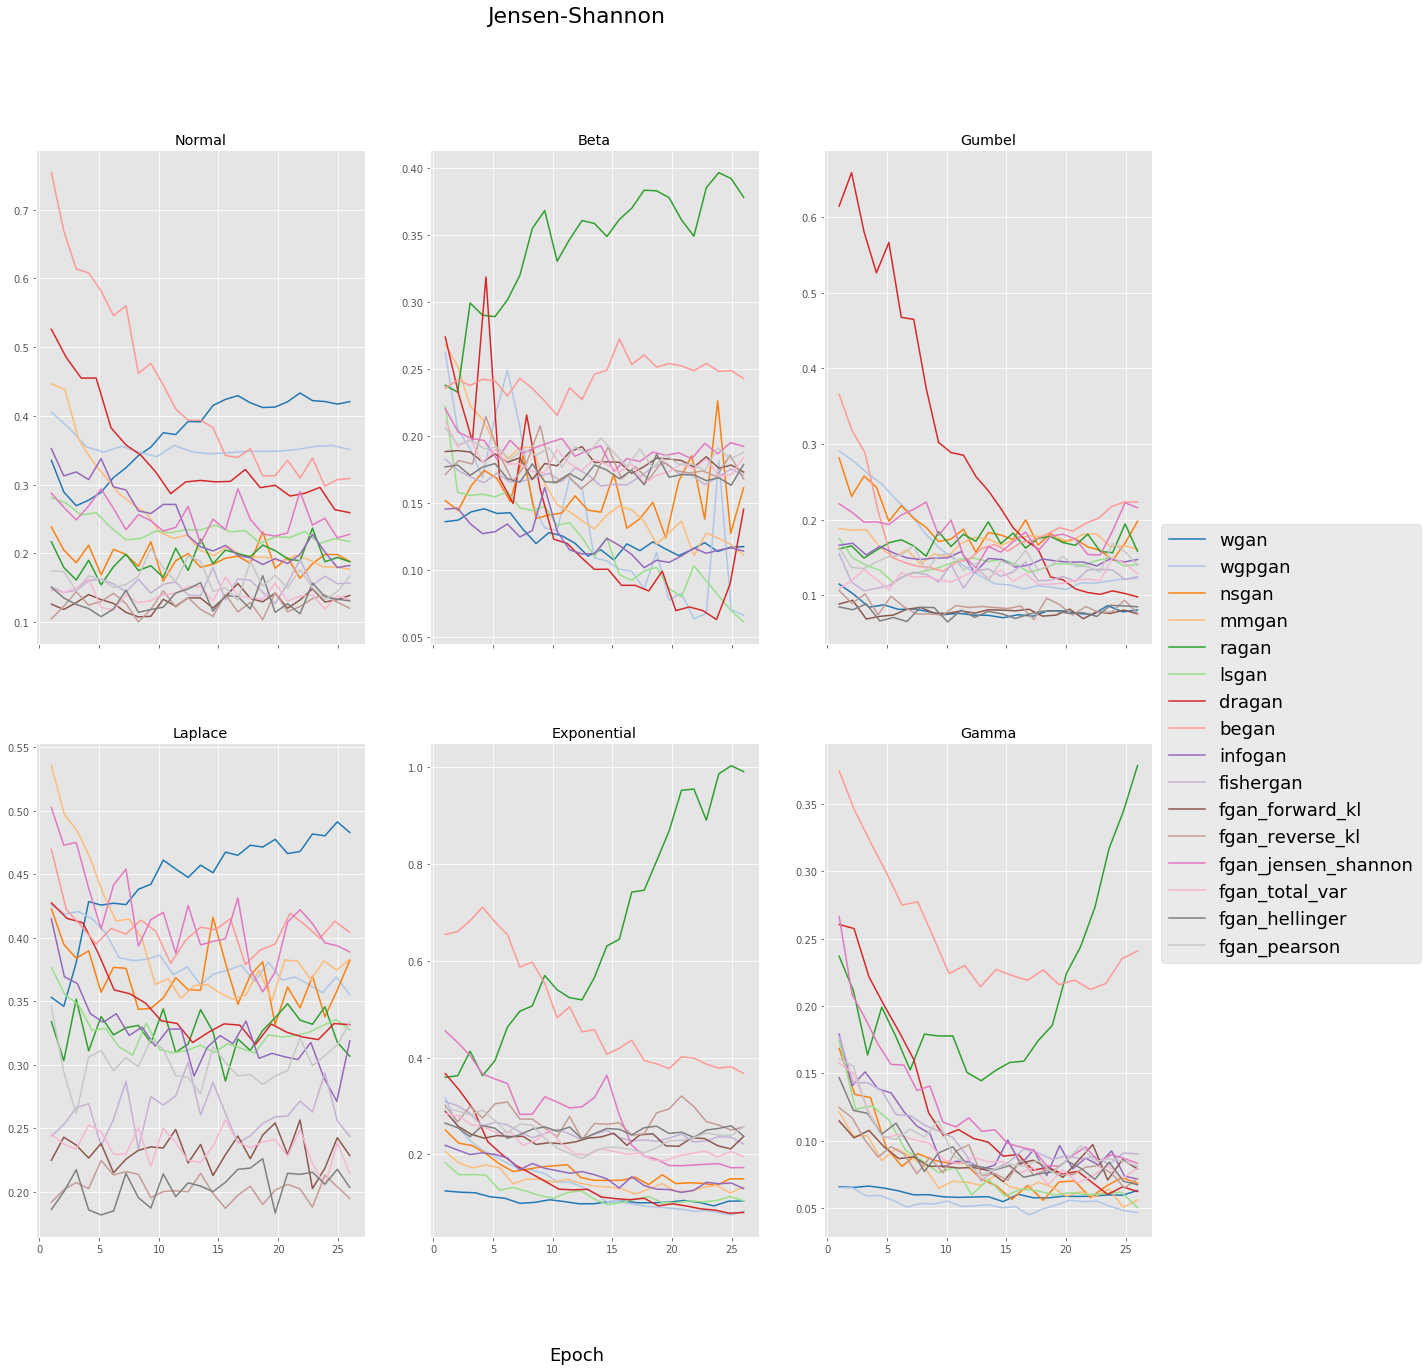

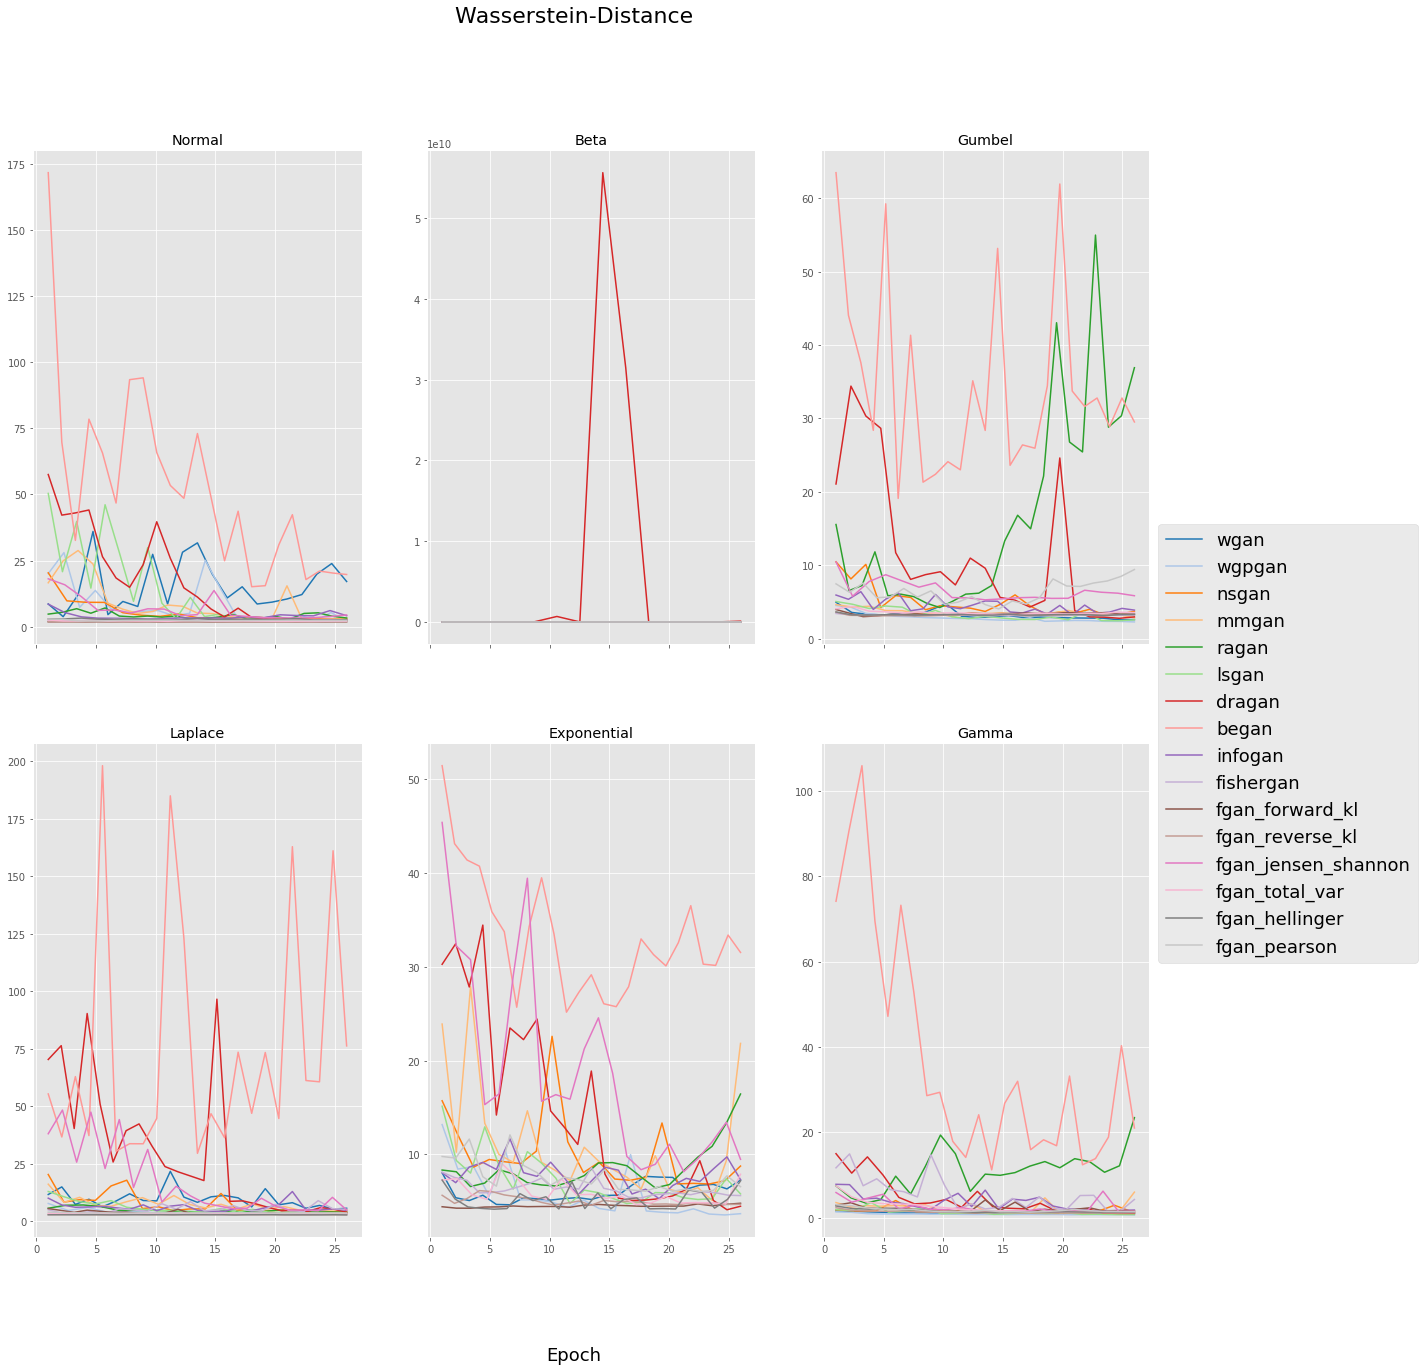

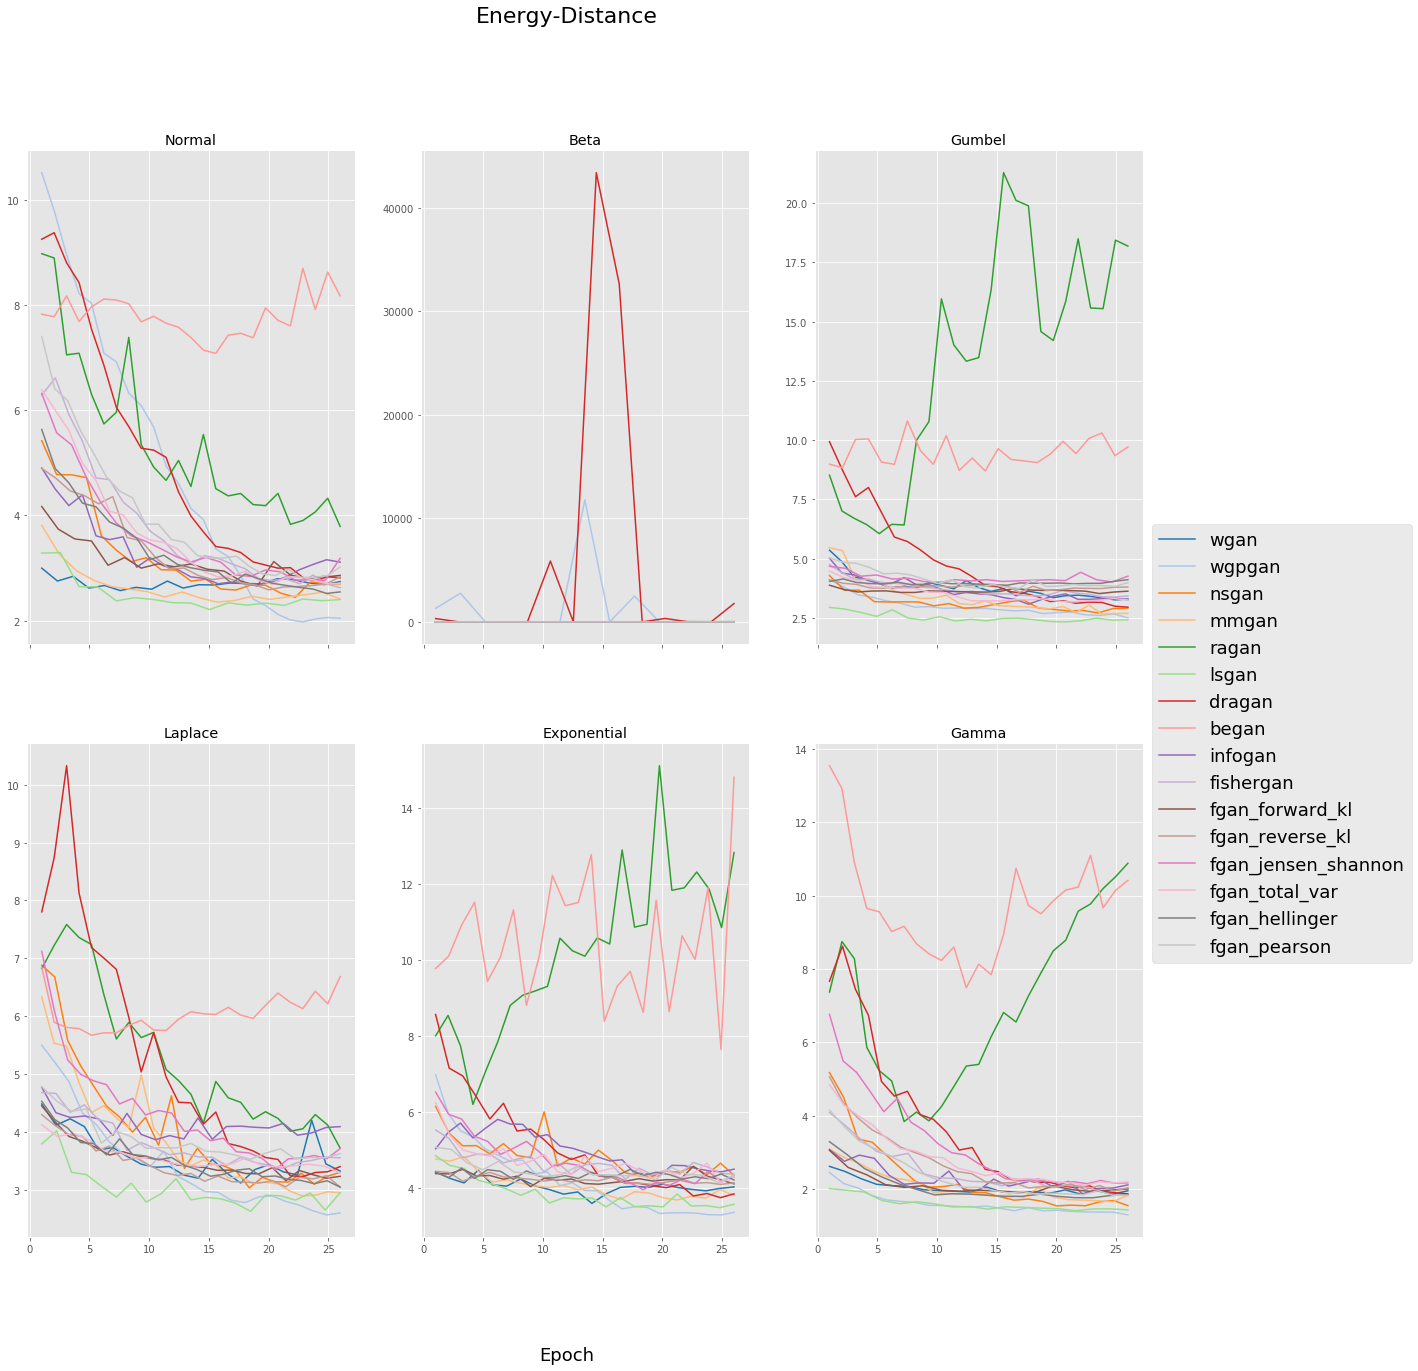

In [645]:
print(""" Plot mean performance across epochs for 100k samples""")
graph_multivariate(optimal_100000, omit_outliers=True, thresh=4.5)

In [647]:
print(""" Print confidence intervals for minimum across all runs """)
rankings_dict = nested_pickle_dict()
param_dict = nested_pickle_dict()

for metric in distance_metrics:
    
    print('\n======================')
    print('{0}'.format(metric))
    print('======================\n')
        
    for samples, optimal in [(1000, optimal_1000), (10000, optimal_10000), (100000, optimal_100000)]:
        
        print('\n{0} Samples \n'.format(samples))

        for distribution in distributions:

            for model_name in model_names:
                
                minimums = np.nanmin(np.array(optimal[model_name][distribution][metric]['values']), axis=1)
                mu, h, low, high = mean_confidence_interval(minimums)
                param_dict[metric][model_name][distribution][samples] = '%.3f ± %.3f' % (np.round(mu, 3), np.round(h, 3))
        
        data = [[key, param_dict[metric][key]['normal'][samples], param_dict[metric][key]['beta'][samples], 
                      param_dict[metric][key]['gumbel'][samples], param_dict[metric][key]['laplace'][samples], 
                      param_dict[metric][key]['exponential'][samples], param_dict[metric][key]['gamma'][samples]]
                 for key in model_names]
        print(tabulate(data, headers=['Model', 'Normal', 'Beta', 'Gumbel', 'Laplace', 'Exponential', 'Gamma']), '\n')
        
        rankings = np.argsort([[eval(i[:4]) if i[:4] != 'nan ' else 1e10 for i in j[1:]] for j in data], axis=0)
        
        for j in range(rankings.shape[1]):
            for idx, name in enumerate(rankings[:, j]):
                if model_names[name] not in rankings_dict[metric][distributions[j]]:
                    rankings_dict[metric][distributions[j]][model_names[name]] = []
                rankings_dict[metric][distributions[j]][model_names[name]].append(idx)

 Print confidence intervals for minimum across all runs 

KL-Divergence


1000 Samples 

Model                Normal         Beta           Gumbel         Laplace        Exponential    Gamma
-------------------  -------------  -------------  -------------  -------------  -------------  -------------
wgan                 0.253 ± 0.034  0.370 ± 0.027  0.144 ± 0.011  0.487 ± 0.034  0.345 ± 0.058  0.151 ± 0.015
wgpgan               0.663 ± 0.148  0.791 ± 0.048  0.480 ± 0.086  1.263 ± 0.195  0.670 ± 0.032  0.279 ± 0.048
nsgan                0.157 ± 0.015  0.373 ± 0.056  0.144 ± 0.007  0.414 ± 0.025  0.486 ± 0.073  0.168 ± 0.021
mmgan                1.823 ± 0.151  0.756 ± 0.069  0.584 ± 0.107  2.050 ± 0.217  0.750 ± 0.037  0.727 ± 0.068
ragan                0.210 ± 0.069  0.451 ± 0.082  0.153 ± 0.010  0.436 ± 0.036  0.522 ± 0.057  0.160 ± 0.026
lsgan                0.573 ± 0.132  0.693 ± 0.059  0.323 ± 0.038  0.811 ± 0.130  0.714 ± 0.035  0.543 ± 0.069
dragan               1.754 ± 0.093  0.7

Model                Normal         Beta           Gumbel         Laplace        Exponential    Gamma
-------------------  -------------  -------------  -------------  -------------  -------------  -------------
wgan                 0.186 ± 0.023  0.083 ± 0.007  0.046 ± 0.004  0.264 ± 0.020  0.066 ± 0.006  0.035 ± 0.003
wgpgan               0.232 ± 0.016  0.048 ± 0.008  0.061 ± 0.004  0.297 ± 0.011  0.062 ± 0.004  0.031 ± 0.002
nsgan                0.072 ± 0.009  0.072 ± 0.008  0.062 ± 0.004  0.211 ± 0.011  0.083 ± 0.004  0.034 ± 0.002
mmgan                0.146 ± 0.015  0.076 ± 0.007  0.073 ± 0.005  0.262 ± 0.010  0.077 ± 0.004  0.036 ± 0.003
ragan                0.088 ± 0.007  0.160 ± 0.007  0.064 ± 0.006  0.215 ± 0.010  0.193 ± 0.012  0.054 ± 0.006
lsgan                0.175 ± 0.008  0.048 ± 0.011  0.073 ± 0.004  0.245 ± 0.009  0.063 ± 0.005  0.031 ± 0.002
dragan               0.200 ± 0.014  0.048 ± 0.012  0.068 ± 0.004  0.263 ± 0.013  0.064 ± 0.010  0.044 ± 0.005
began             

Model                Normal         Beta            Gumbel         Laplace        Exponential    Gamma
-------------------  -------------  --------------  -------------  -------------  -------------  -------------
wgan                 2.138 ± 0.721  8.136 ± 2.402   3.392 ± 1.205  3.259 ± 1.332  3.914 ± 1.931  2.038 ± 0.739
wgpgan               2.802 ± 0.874  8.859 ± 2.289   3.881 ± 1.375  3.617 ± 1.314  4.797 ± 1.951  1.936 ± 0.957
nsgan                3.740 ± 1.318  9.550 ± 2.679   4.093 ± 1.663  4.276 ± 1.553  5.484 ± 2.308  2.486 ± 0.918
mmgan                3.343 ± 0.796  9.878 ± 2.881   4.156 ± 1.693  4.085 ± 1.350  5.055 ± 2.023  3.308 ± 1.722
ragan                3.890 ± 0.732  9.941 ± 2.968   4.941 ± 1.397  4.431 ± 1.370  5.586 ± 1.635  2.834 ± 0.979
lsgan                3.209 ± 1.024  9.591 ± 2.779   3.819 ± 1.608  3.491 ± 1.166  5.006 ± 1.890  2.728 ± 1.260
dragan               4.852 ± 1.322  10.670 ± 3.237  6.135 ± 2.108  5.149 ± 1.615  6.051 ± 1.618  4.022 ± 1.120
began    

In [648]:
print(""" Get relative ranking performance based on mean minimum performance\n """)


print('0 is the best performance.\n1st entry: 1k samples, 2nd: 10k, 3rd: 100k \n')
for metric in distance_metrics:
    print('========{0}=======\n'.format(metric))
    
    print(tabulate([[key, rankings_dict[metric]['normal'][key], rankings_dict[metric]['beta'][key], rankings_dict[metric]['gumbel'][key],
                          rankings_dict[metric]['laplace'][key], rankings_dict[metric]['exponential'][key], rankings_dict[metric]['gamma'][key]] 
                    for key in model_names], 
                   headers=['Model', 'Normal', 'Beta', 'Gumbel', 'Laplace', 'Exponential', 'Gamma']), '\n')

 Get relative ranking performance based on mean minimum performance
 
0 is the best performance.
1st entry: 1k samples, 2nd: 10k, 3rd: 100k 

========KL-Divergence=======

Model                Normal        Beta          Gumbel        Laplace       Exponential    Gamma
-------------------  ------------  ------------  ------------  ------------  -------------  ------------
wgan                 [8, 8, 9]     [4, 3, 10]    [1, 6, 6]     [8, 8, 10]    [0, 0, 0]      [5, 3, 3]
wgpgan               [11, 11, 13]  [14, 11, 0]   [12, 13, 10]  [12, 12, 12]  [12, 6, 2]     [10, 7, 4]
nsgan                [4, 4, 3]     [5, 4, 3]     [2, 0, 0]     [3, 5, 2]     [7, 1, 5]      [6, 6, 0]
mmgan                [14, 13, 11]  [13, 12, 7]   [13, 12, 12]  [14, 14, 15]  [14, 12, 6]    [14, 13, 7]
ragan                [7, 7, 7]     [9, 9, 13]    [6, 8, 8]     [7, 7, 7]     [8, 11, 14]    [7, 8, 10]
lsgan                [9, 12, 12]   [10, 10, 1]   [11, 10, 13]  [9, 11, 13]   [13, 10, 1]    [13, 12, 1]
dragan 

 Plot mean minimum performance with error bars as a function of number samples 


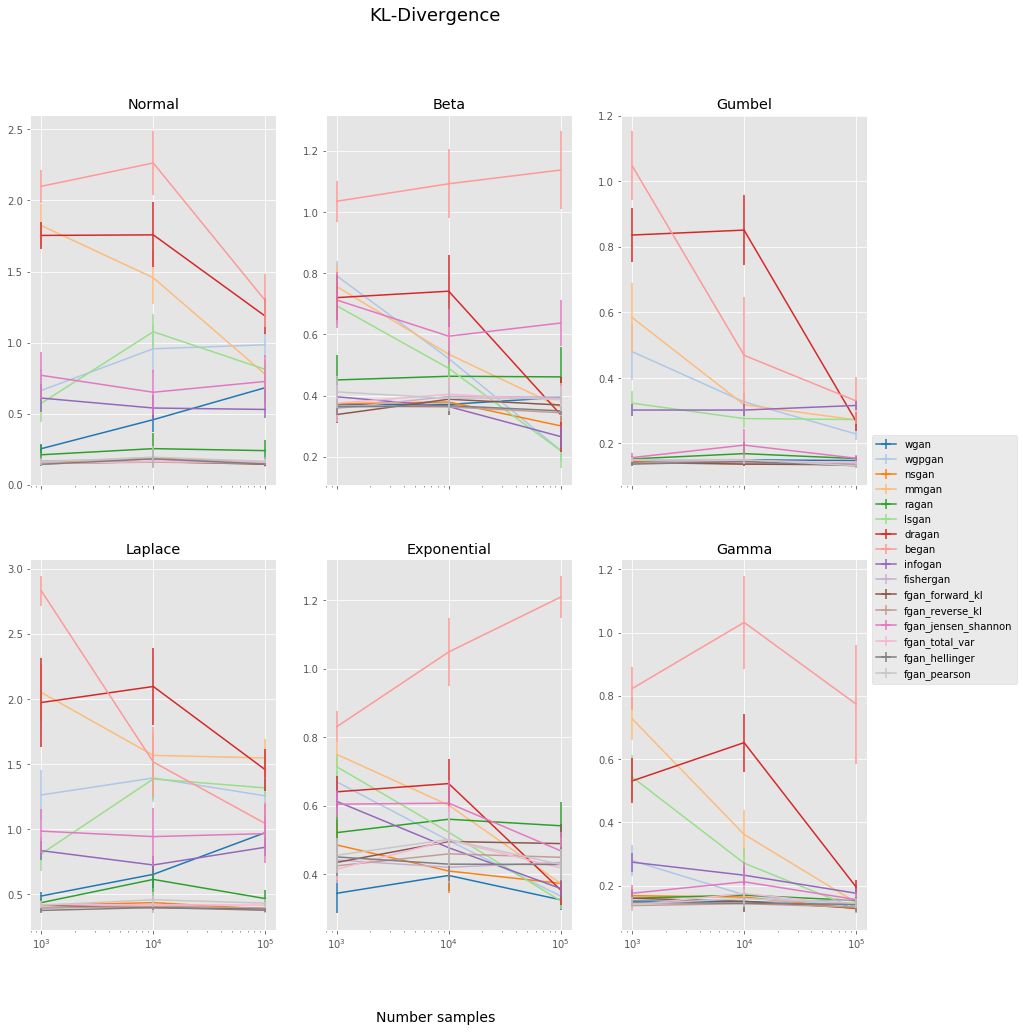

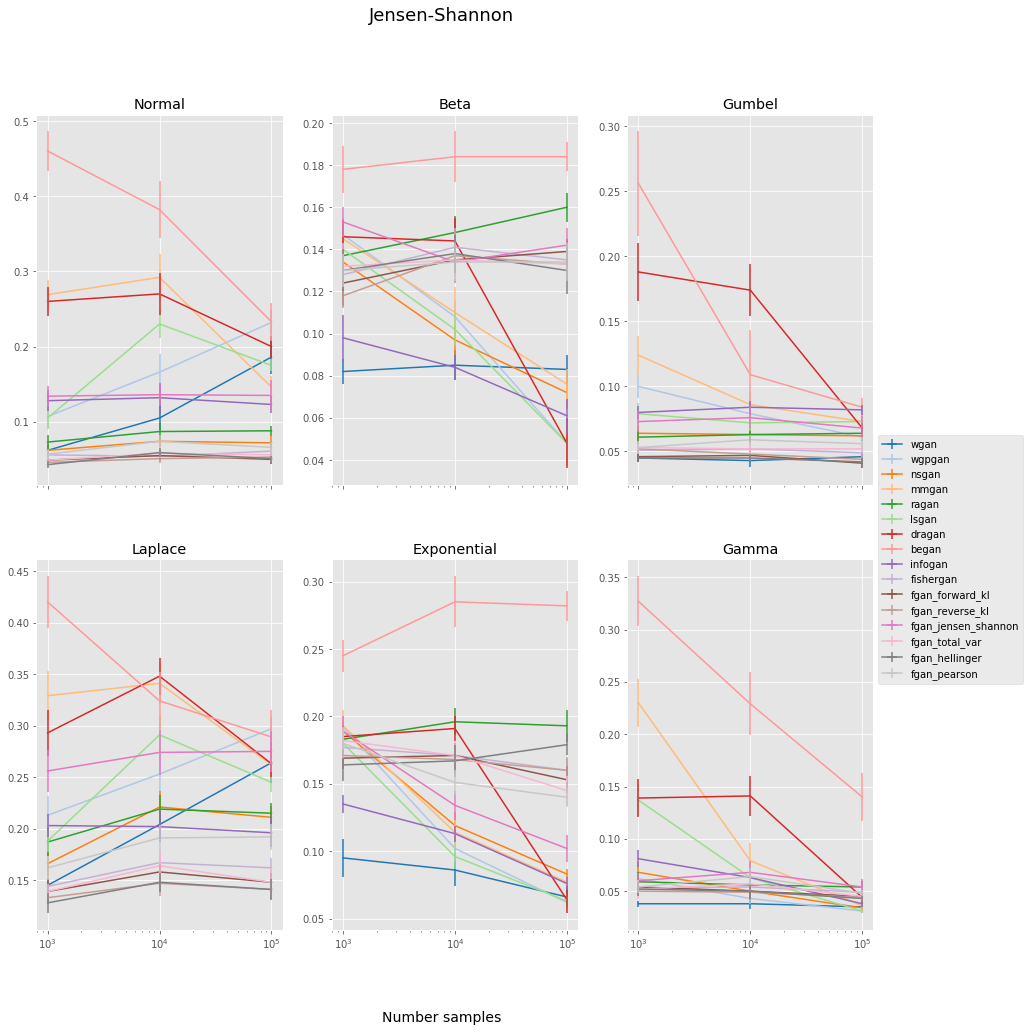

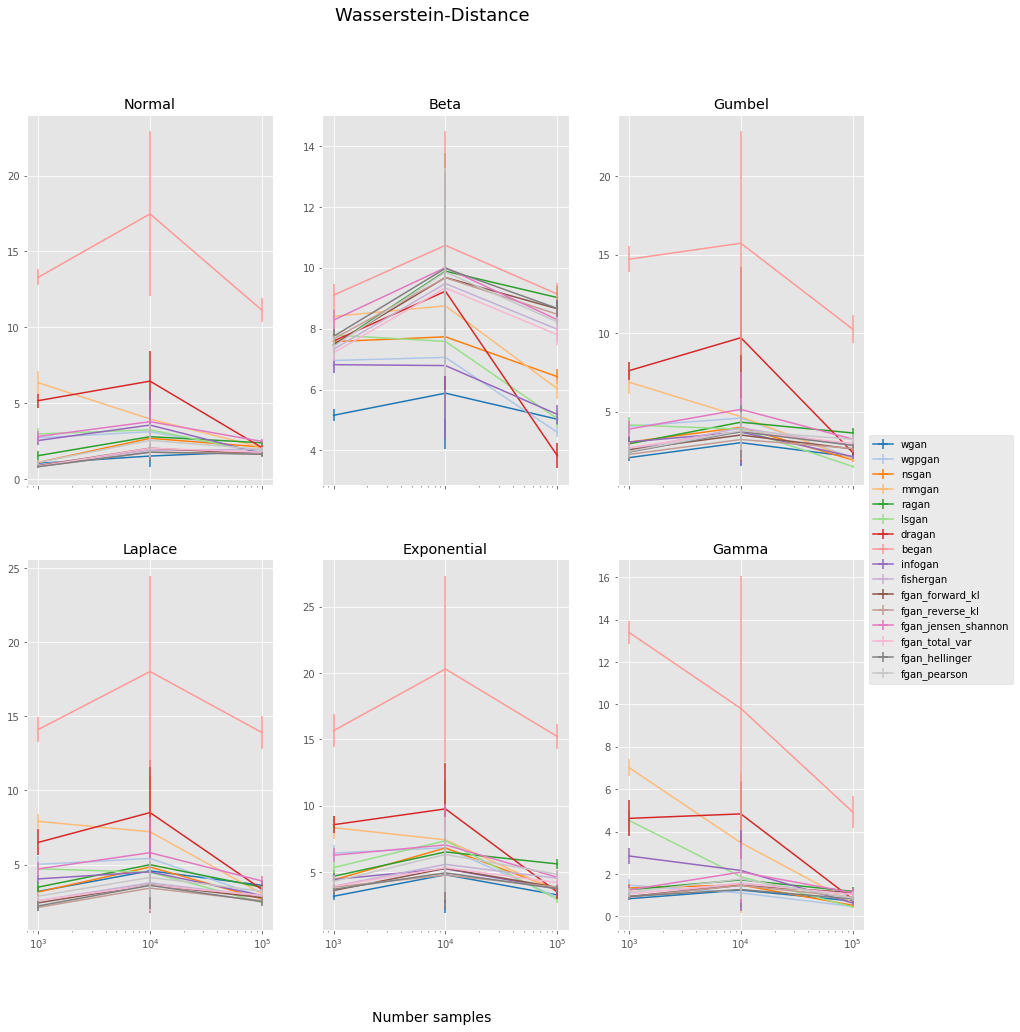

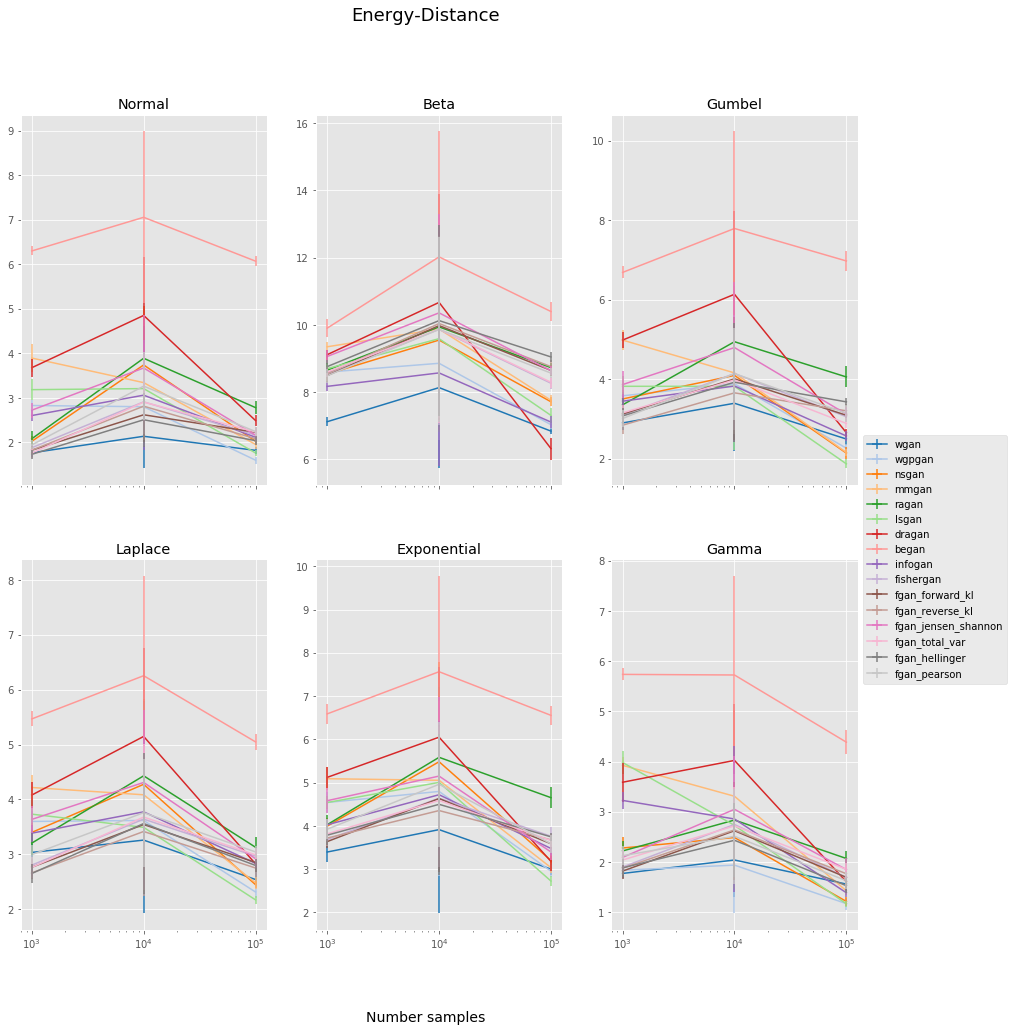

In [649]:
print(""" Plot mean minimum performance with error bars as a function of number samples """)

for metric in distance_metrics:
    
    fig, axes = plt.subplots(2, 3, sharex=True, sharey=False, figsize=(15,15))
                
    for d_idx, distribution in enumerate(distributions):

        for idx, model_name in enumerate(model_names):

            x, y, yerr = [], [], []
            for key, val in param_dict[metric][model_name][distribution].items():
                if key == 'error':
                    continue

                mu, err = val.split('±')
                x.append(float(key)), y.append(float(mu)), yerr.append(float(err))

            axes[plt_idx[d_idx][0], plt_idx[d_idx][1]].errorbar(x, y, xerr=0, yerr=yerr,
                                                                  barsabove=True, label=model_name,
                                                                  c=palette[idx], ecolor=palette[idx])
            axes[plt_idx[d_idx][0], plt_idx[d_idx][1]].set_title("{0}".format(distribution.capitalize()))

    plt.xscale('log')
    fig.suptitle("{0}".format(metric), fontsize=18)
    fig.text(0.5, 0.04, "Number samples", ha='center', fontsize=14)
    plt.legend(loc='center left', bbox_to_anchor=(1, 1))
    plt.show()

In [650]:
# Visualizes the same thing as above but in table form
print(""" Print confidence interval error 3-tuples for number of samples """)
print('1st entry is 1k samples, 2nd is 10k, 3rd 100k')

for metric in distance_metrics:
    
    print('\n======================')
    print('{0}'.format(metric))
    print('======================\n')
                
    for distribution in distributions:

        for model_name in model_names:
            
            param_dict[metric][model_name][distribution]['error'] = []

            for sample in [1000, 10000, 100000]:
                param_dict[metric][model_name][distribution]['error'].append(float(param_dict[metric][model_name][distribution][sample].split('±')[1]))

    data = [[key, param_dict[metric][key]['normal']['error'], param_dict[metric][key]['beta']['error'], 
                  param_dict[metric][key]['gumbel']['error'], param_dict[metric][key]['laplace']['error'], 
                  param_dict[metric][key]['exponential']['error'], param_dict[metric][key]['gamma']['error']]
             for key in model_names]
    print(tabulate(data, headers=['Model', 'Normal', 'Beta', 'Gumbel', 'Laplace', 'Exponential', 'Gamma']), '\n')

 Print confidence interval error 3-tuples for number of samples 
1st entry is 1k samples, 2nd is 10k, 3rd 100k

KL-Divergence

Model                Normal                 Beta                   Gumbel                 Laplace                Exponential            Gamma
-------------------  ---------------------  ---------------------  ---------------------  ---------------------  ---------------------  ---------------------
wgan                 [0.034, 0.084, 0.104]  [0.027, 0.031, 0.037]  [0.011, 0.014, 0.012]  [0.034, 0.106, 0.122]  [0.058, 0.046, 0.031]  [0.015, 0.021, 0.01]
wgpgan               [0.148, 0.17, 0.084]   [0.048, 0.053, 0.034]  [0.086, 0.026, 0.019]  [0.195, 0.185, 0.075]  [0.032, 0.055, 0.016]  [0.048, 0.02, 0.009]
nsgan                [0.015, 0.07, 0.017]   [0.056, 0.038, 0.032]  [0.007, 0.008, 0.008]  [0.025, 0.041, 0.018]  [0.073, 0.065, 0.033]  [0.021, 0.034, 0.008]
mmgan                [0.151, 0.188, 0.104]  [0.069, 0.073, 0.039]  [0.107, 0.035, 0.023]  [0.217, 0.1

In [651]:
print(""" Get number of different hyperparameters for each minimum run """)
print('1st entry: 1k samples, 2nd: 10k, 3rd: 100k')

for metric in distance_metrics:
    
    print('\n======================')
    print('{0}'.format(metric))
    print('======================\n')
    
    param_dict = nested_pickle_dict()
        
    for samples, optimal in [(1000, optimal_1000), (10000, optimal_10000), (100000, optimal_100000)]:
        
        for distribution in distributions:
            
            for model_name in model_names:
                if distribution not in param_dict[model_name]:
                    param_dict[model_name][distribution] = []
                param_dict[model_name][distribution].append(len(set([tuple(t) for t in optimal[model_name][distribution][metric]['parameters']])))

    print(tabulate([[key, param_dict[key]['normal'], param_dict[key]['beta'], param_dict[key]['gumbel'],
                          param_dict[key]['laplace'], param_dict[key]['exponential'], param_dict[key]['gamma']]
                     for key in model_names],
                    headers=['Model', 'Normal', 'Beta', 'Gumbel', 'Laplace', 'Exponential', 'Gamma']))

 Get number of different hyperparameters for each minimum run 
1st entry: 1k samples, 2nd: 10k, 3rd: 100k

KL-Divergence

Model                Normal        Beta         Gumbel        Laplace       Exponential    Gamma
-------------------  ------------  -----------  ------------  ------------  -------------  ------------
wgan                 [11, 16, 8]   [8, 9, 9]    [8, 10, 11]   [13, 14, 10]  [11, 12, 10]   [12, 12, 12]
wgpgan               [9, 7, 5]     [10, 4, 4]   [10, 5, 5]    [5, 7, 7]     [12, 5, 10]    [15, 11, 14]
nsgan                [6, 8, 8]     [8, 8, 8]    [7, 9, 8]     [7, 9, 7]     [6, 5, 9]      [9, 10, 15]
mmgan                [12, 8, 5]    [7, 5, 7]    [9, 5, 5]     [12, 6, 11]   [8, 11, 14]    [11, 8, 8]
ragan                [9, 10, 9]    [9, 8, 9]    [8, 8, 7]     [9, 8, 9]     [8, 7, 8]      [11, 11, 10]
lsgan                [6, 9, 10]    [10, 4, 5]   [10, 7, 9]    [8, 9, 9]     [14, 8, 13]    [11, 6, 14]
dragan               [17, 9, 9]    [12, 8, 7]   [17, 14, 